In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.cm as cm
from matplotlib import cm
from matplotlib.patches import Circle
import math

pd.set_option('display.max_rows', 60)

In [3]:
# setting values

path = "../Datasets/test - straight variantion.csv"
dataset_path = "../Datasets/train - simple agent.csv"
n_targets = 8

In [4]:
# reading from the file 
names = ['timestamp', 
        'id', 
        'x', 'y', 'z', 
        'head orientation', 
        'body orientation', 
        'true target', 
        'probability 0',
        'probability 1',
        'probability 2',
        'probability 3',
        'probability 4',
        'probability 5',
        'probability 6',
        'probability 7',
        ]
df = pd.read_csv(path, header=None, names=names)
df.dropna(inplace=True)

data = pd.read_csv(dataset_path, header=None, names=names)

In [5]:
# data_t = pd.concat([data_t, df], ignore_index=True)
data_t = data

## Analyze dataset

In [6]:
n_trials = len(data_t[['timestamp', 'id', 'true target']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = data_t[['timestamp', 'id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
min_trials = trials_targets.min()
print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  6224
The number of trials for each target:
              id
true target     
0            778
1            778
2            778
3            778
4            778
5            778
6            778
7            778


In [7]:
groups = data_t[['timestamp', 'id', 'true target']].drop_duplicates().reset_index(drop=True)
groups = groups.groupby(["true target"], as_index=False).sample(min_trials).sort_index()
data1 = pd.merge(groups[['timestamp', 'id']], data_t, on=["timestamp", "id"])
n_trials = len(data1[['timestamp', 'id', 'true target']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = data1[['timestamp', 'id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
min_trials = trials_targets.min()
print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  6224
The number of trials for each target:
              id
true target     
0            778
1            778
2            778
3            778
4            778
5            778
6            778
7            778


In [86]:
new_data = pd.DataFrame()
data_trans = data1.copy()
new_data = pd.concat([new_data, data_trans])
for i in range(1, 8):
    

    data_trans['x'] = math.cos(-i * math.pi/4) * data1['x'] - math.sin(-i * math.pi/4) * data1['z']
    data_trans['z'] = math.sin(-i * math.pi/4) * data1['x'] + math.cos(-i * math.pi/4) * data1['z']
    data_trans['true target'] = i
    data_trans['head orientation'] = (data1['head orientation'] + i * 45) % 360
    data_trans['body orientation'] = (data1['body orientation'] + i * 45) % 360
    new_data = pd.concat([new_data, data_trans])
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 16)) #figsize=(7, 18),

    # tmp = data_trans[data_trans['true target'] == i]
    # ax.scatter(tmp['x'], tmp['z'], s=0.01)
    # ax.set_xlim([-5, 5])
    # ax.set_ylim([-5, 5])
    # ax.title.set_text(f'Straight Line with Variation for Target {i}' )
    # ax.set_aspect('equal')
    # # circle = Circle((, ), 2, facecolor='none', linewidth=0.5, fill=False, edgecolor='r')
    # # ax.add_patch(circle)
    # # plt.grid()
    # plt.annotate(f'Count: {trials_targets[0]}', [3, 4])
# plt.savefig("../Plots/straight variation small random")

In [87]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 16)) #figsize=(7, 18),

circle_center = [(-1, 0), (-1/math.sqrt(2), 1/math.sqrt(2)), (0, 1), (1/math.sqrt(2), 1/math.sqrt(2)), (1, 0), (1/math.sqrt(2), -1/math.sqrt(2)), (0, -1), (-1/math.sqrt(2), -1/math.sqrt(2))]
for i, ax in enumerate(axes.flat):
    tmp = data1[data1['true target'] == i]
    # ax.scatter(tmp['x'], tmp['z'], s=0.001)
    plt.arrow(tmp['x'], tmp['z'], math.cos(tmp['head orientation']), math.sin(tmp['head orientation']))
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.title.set_text(f'Target {i}' )
    ax.set_aspect('equal')
    circle = Circle(circle_center[i], 2, facecolor='none', linewidth=0.5, fill=False, edgecolor='r')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=30, c='r')
    # ax.text(0, 0.5, 'center', fontsize = 20)
    # plt.grid()
# plt.savefig("../Plots/rotated and translated data")

(-5.0, 5.0)

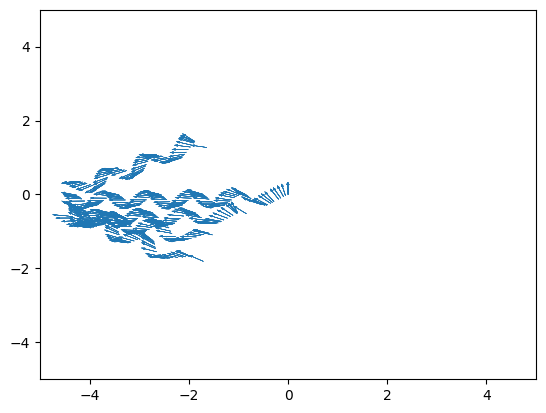

In [14]:
tmp2 = data1[(data1['true target'] == 0) & (data1['id'].isin(range(5)))] 

for i, tmp in tmp2.iterrows():
    plt.arrow(tmp['x'], tmp['z'], math.sin(math.radians(tmp['head orientation']))/3, math.cos(math.radians(tmp['head orientation']))/3
          ,shape='full', lw=0, length_includes_head=True, width=0.01, head_width=0.05)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
# plt.savefig("../Plots/sample orientation")
# plt.yl

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

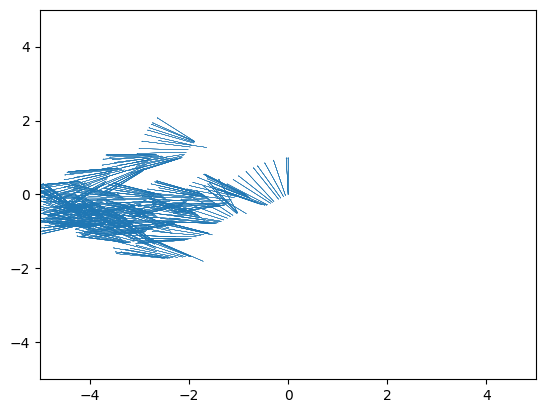

In [10]:
tmp = data1[(data1['true target'] == 0) & (data1['id'].isin(range(5)))]
# ax.scatter(tmp['x'], tmp['z'], s=0.001)
angles = tmp['head orientation'].apply(lambda x: math.radians(x))
dy = angles.apply(lambda x: math.cos(x))
dx = angles.apply(lambda x: math.sin(x))

# plt.arrow(tmp['x'], tmp['z'], dx, dy)
for index, t in tmp.iterrows():
    # print(t)
    plt.arrow(t['x'], t['z'], math.sin(math.radians(t['head orientation'])), math.cos(math.radians(t['head orientation']))
              ,shape='full', lw=0, length_includes_head=True, width=0.005)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
# plt.title.set_text(f'Target {i}' )
# plt.set_aspect('equal')

# circle = Circle(circle_center[i], 2, facecolor='none', linewidth=0.5, fill=False, edgecolor='r')
# ax.add_patch(circle)
plt.scatter([0], [0], s=30, c='r')

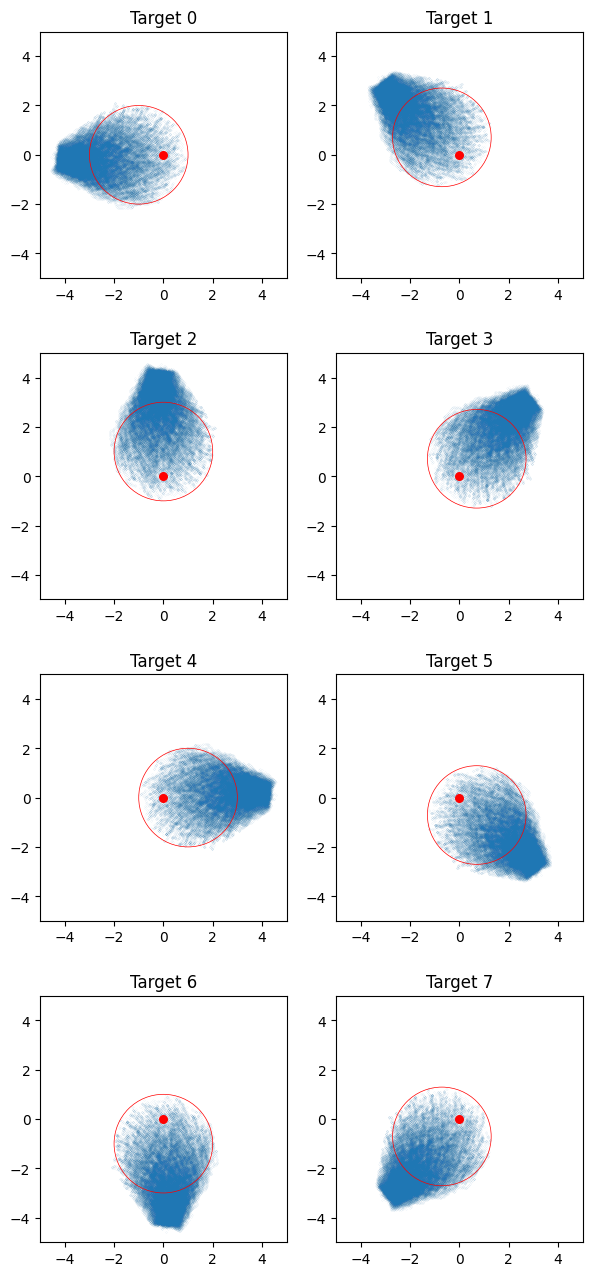

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 16)) #figsize=(7, 18),

circle_center = [(-1, 0), (-1/math.sqrt(2), 1/math.sqrt(2)), (0, 1), (1/math.sqrt(2), 1/math.sqrt(2)), (1, 0), (1/math.sqrt(2), -1/math.sqrt(2)), (0, -1), (-1/math.sqrt(2), -1/math.sqrt(2))]
for i, ax in enumerate(axes.flat):
    tmp = new_data[new_data['true target'] == i]
    ax.scatter(tmp['x'], tmp['z'], s=0.001)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.title.set_text(f'Target {i}' )
    ax.set_aspect('equal')
    circle = Circle(circle_center[i], 2, facecolor='none', linewidth=0.5, fill=False, edgecolor='r')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=30, c='r')
    # ax.text(0, 0.5, 'center', fontsize = 20)
    # plt.grid()
plt.savefig("../Plots/rotated and translated data")

In [17]:
new_data.to_csv("../Plots/train - simple agent.csv", header=False, index=False)

In [ ]:
data1.to_csv(dataset_path, header=False, index=False)

In [ ]:
initial_positions = data.groupby(["timestamp", "id"], as_index=False).first()
initial_positions
plt.scatter(initial_positions['x'], initial_positions['z'], s=10)
plt.ylim(-4, 4)
plt.show()

## Analyze results

In [44]:
# adding the predicted target as a new column
def pred(x):
    tmp = x[-n_targets:].copy().astype(float).reset_index(drop=True)
    if (tmp.min() == tmp.max()):
        return None
    else:    
        pred = tmp.idxmax()
        return pred
    
df["prediction target"] = df.apply(lambda x: pred(x), axis=1)
df["similarity"] = df.apply(lambda x: 1 if x["true target"] == x["prediction target"] else 0, axis=1)

In [45]:
df

,timestamp,id,x,y,z,head orientation,body orientation,true target,probability 0,probability 1,probability 2,probability 3,probability 4,probability 5,probability 6,probability 7,prediction target,similarity
1,3/8/2023 3:10:51 PM,0,-7.718336e-08,0.541667,-4.237518e-07,2.400001,14.40001,5,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,NaN,0
2,3/8/2023 3:10:51 PM,0,7.849924e-02,0.541667,-1.471909e-02,14.400010,26.38013,5,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,NaN,0
3,3/8/2023 3:10:51 PM,0,1.653370e-01,0.541667,-3.100116e-02,26.380130,33.01196,5,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,NaN,0
4,3/8/2023 3:10:51 PM,0,2.216354e-01,0.541667,-4.155710e-02,33.011960,37.79356,5,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,NaN,0
5,3/8/2023 3:10:51 PM,0,2.727766e-01,0.541667,-5.114604e-02,37.793560,42.52458,5,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,-0.125000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19454,3/8/2023 3:40:24 PM,165,-4.902798e-02,0.541667,4.119515e+00,19.142810,19.32275,2,-0.167467,-0.072342,-0.005871,-0.084453,-0.167467,-0.167467,-0.167467,-0.167467,2.0,1
19455,3/8/2023 3:40:24 PM,165,-3.937572e-02,0.541667,4.143395e+00,19.322750,18.27105,2,-0.169029,-0.072205,-0.005956,-0.076696,-0.169029,-0.169029,-0.169029,-0.169029,2.0,1
19456,3/8/2023 3:40:24 PM,165,-3.676533e-02,0.541667,4.177846e+00,18.271050,16.09489,2,-0.169395,-0.074508,-0.006066,-0.072450,-0.169395,-0.169395,-0.169395,-0.169395,2.0,1
19457,3/8/2023 3:40:24 PM,165,-4.228511e-02,0.541667,4.218798e+00,16.094890,13.33246,2,-0.170939,-0.074892,-0.005809,-0.064603,-0.170939,-0.170939,-0.170939,-0.170939,2.0,1


In [46]:
n_trials = len(df[['id']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = df[['id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
min_trials = trials_targets.min()

print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  166
The number of trials for each target:
             id
true target    
0            25
1            15
2            22
3            26
4            18
5            19
6            21
7            20


In [68]:
groups = df[['id', 'true target']].drop_duplicates().reset_index(drop=True)
groups = groups.groupby(["true target"], as_index=False).sample(min_trials)
data1 = pd.merge(groups[['id']], df, on=["id"])
n_trials = len(data1[['id']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = data1[['id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
print("The number of trials for each target:")
print(trials_targets.to_frame())
df = data1.copy()

The number of trials are:  120
The number of trials for each target:
             id
true target    
0            15
1            15
2            15
3            15
4            15
5            15
6            15
7            15


In [69]:
timestamp = df[['timestamp']].drop_duplicates()

columns=["timestamp", 
         "trial points", 
         "accuracy", 
         "target", 
         "predicted targets", 
         "#predicted targets",
         "#predicted targets/length %"]

accu = pd.DataFrame(columns=columns)

for index, t in timestamp.iterrows():
    trial = df[df["timestamp"] == t["timestamp"]]
    accuracy = trial["similarity"].sum() / len(trial)
    target = trial["true target"].unique() 
    predicted_targets = trial["prediction target"].unique()
    predicted_targets = predicted_targets[~np.isnan(predicted_targets)]
    
    match = trial[trial["true target"] == trial["prediction target"]]
    first_match_index = match.index[0] + 1 if not match.empty else trial.index[-1] + 1
    wrong = first_match_index - trial.index[0]

    row = {"timestamp": [t["timestamp"]], 
           "trial points": [len(trial)], 
           "accuracy": [accuracy],
           "target": target,
           "predicted targets" : [predicted_targets],
           "#predicted targets" : [len(predicted_targets)],
           "#predicted targets/length %" : [len(predicted_targets) / len(trial) * 100],
           "wrong prediction time till correct": wrong,
           "wrong prediction time till correct/length": wrong / len(trial)
           }

    accu = pd.concat([accu, pd.DataFrame(row)], ignore_index=True)    

accu[["trial points", "target", "#predicted targets"]] = accu[["trial points", "target", "#predicted targets"]].astype(str).astype(int)
accu.head()


,timestamp,trial points,accuracy,target,predicted targets,#predicted targets,#predicted targets/length %,wrong prediction time till correct,wrong prediction time till correct/length
0,3/8/2023 3:15:28 PM,109,0.660550,0,[0.0],1,0.917431,38.0,0.348624
1,3/8/2023 3:21:41 PM,118,0.618644,0,[0.0],1,0.847458,46.0,0.389831
2,3/8/2023 3:18:04 PM,114,0.649123,0,[0.0],1,0.877193,41.0,0.359649
3,3/8/2023 3:12:30 PM,123,0.691057,0,[0.0],1,0.813008,39.0,0.317073
4,3/8/2023 3:17:14 PM,105,0.647619,0,[0.0],1,0.952381,38.0,0.361905


In [72]:
accu[accu['#predicted targets'] >1]

,timestamp,trial points,accuracy,target,predicted targets,#predicted targets,#predicted targets/length %,wrong prediction time till correct,wrong prediction time till correct/length
65,3/8/2023 3:23:53 PM,153,0.320261,4,"[0.0, 5.0, 4.0]",3,1.960784,105.0,0.686275


### Number of predicted targets in relation to trial length 

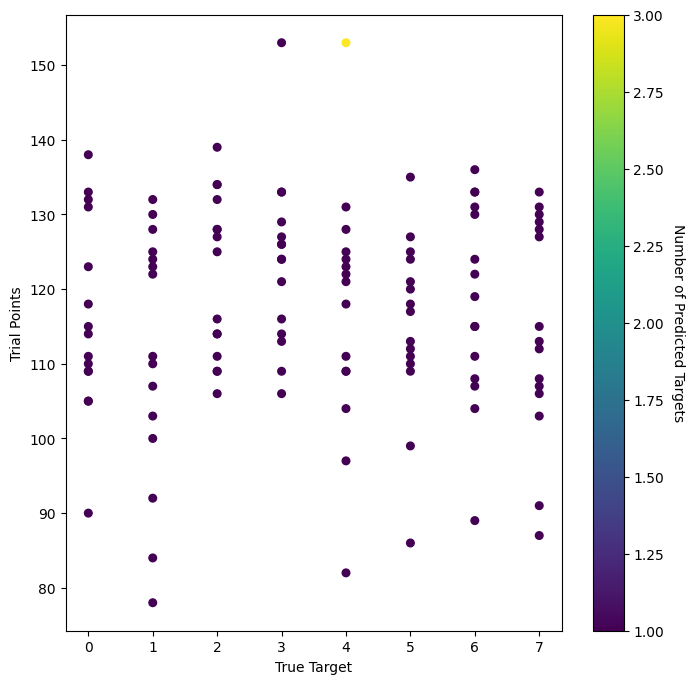

In [70]:
fig = plt.figure(figsize=(8,8))

plt.scatter(accu["target"], accu["trial points"], c = accu["#predicted targets"], s=30)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of Predicted Targets', rotation=270, labelpad=15)

plt.xlabel("True Target")
plt.ylabel("Trial Points")
# plt.set_aspect('equal')
plt.savefig("../Plots/Number of predicted targets in relation to trial length")
plt.show()


In [ ]:
# df = accu.copy()

# width = depth = -0.1

# xpos = df["target"] - width/2  # x coordinates of each bar
# ypos = df["trial points"] - depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["#predicted targets"]

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)

# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth*3, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel("True Target")
# ax.set_ylabel("Trial Points")
# ax.set_zlabel("Number of Predicted Targets")
# plt.savefig("../Plots/Number of predicted targets in relation to trial length")
# plt.show()

### Most frequent predicted targets for each target

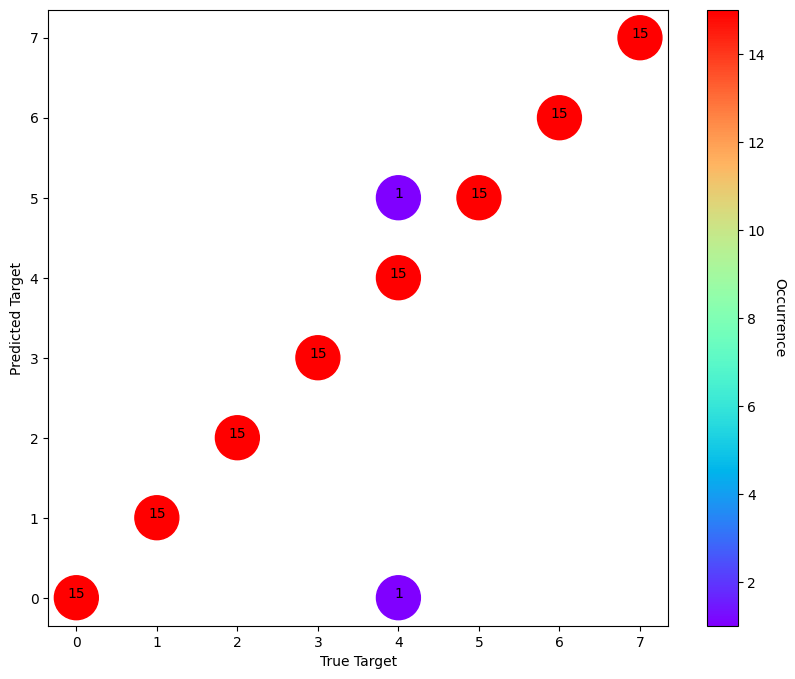

In [71]:
df1 = accu[["timestamp", "trial points", "accuracy", "target", "predicted targets"]].explode("predicted targets")
df1 = df1.groupby(["target", "predicted targets"], as_index=False)["timestamp"].count() 

fig = plt.figure(figsize=(10,8))
plt.scatter(df1["target"], df1["predicted targets"], c = df1["timestamp"], cmap='rainbow', s=1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Occurrence", rotation=270, labelpad=15)

for i, txt in enumerate(df1["timestamp"]):
    plt.annotate(txt, (df1["target"][i], df1["predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.savefig("../Plots/Most frequent predicted targets for each target")
plt.show()

In [ ]:
# # most frequent predicted targets for each target
 
# df = accu[["timestamp", "trial points", "accuracy", "target", "predicted targets"]].explode("predicted targets")
# df = df.groupby(["target", "predicted targets"], as_index=False)["timestamp"].count()

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)
# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# width = depth = -0.1

# xpos = df["target"] - width/2  # x coordinates of each bar
# ypos = df["predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["timestamp"]

# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel('True Target')
# ax.set_ylabel('Predicted Target')
# ax.set_zlabel('Occurrence')
# plt.savefig("../Plots/Most frequent predicted targets for each target")
# plt.show()

### 

In [73]:
res = accu.groupby(["target", "#predicted targets"], as_index=False)["timestamp"].count()

res1 = accu.groupby(["target", "#predicted targets"], as_index=False).mean()

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)
# res1["colors"] = res1.apply(lambda x: cs[int(x["target"])], axis=1) 
res1

res = pd.merge(res, res1, on = ["target", "#predicted targets"])
# res

C:\Users\shokoofehv\AppData\Local\Temp\ipykernel_15988\660952951.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res1 = accu.groupby(["target", "#predicted targets"], as_index=False).mean()


### Number of predicted targets for each target 

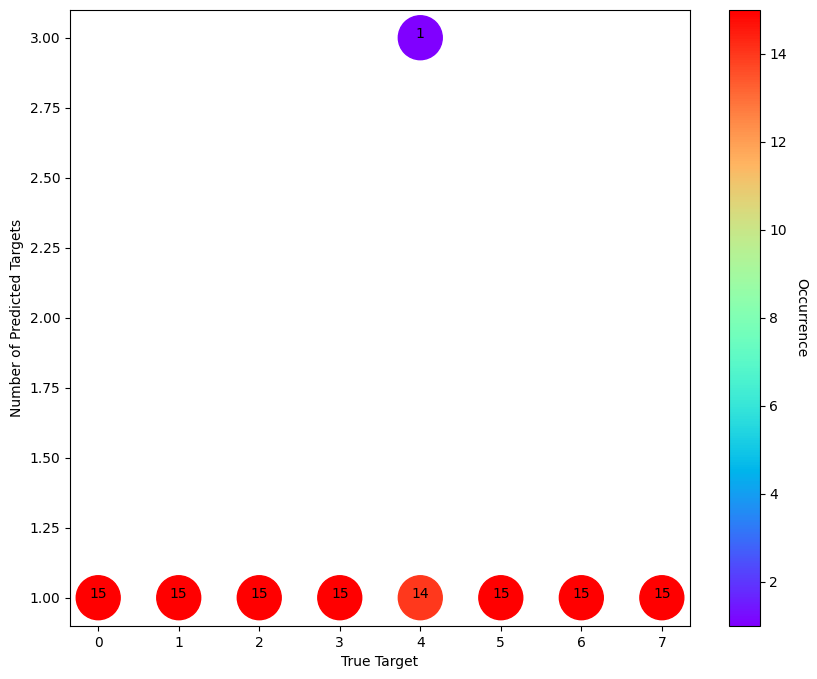

In [74]:
fig = plt.figure(figsize=(10,8))
plt.scatter(res["target"], res["#predicted targets"], c = res["timestamp"], cmap='rainbow', s=1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Occurrence", rotation=270, labelpad=15)

for i, txt in enumerate(res["timestamp"]):
    plt.annotate(txt, (res["target"][i], res["#predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Number of Predicted Targets")
plt.savefig("../Plots/Number of predicted targets for each target")
plt.show()

In [ ]:
# # number of wrong predictions 

# width = depth = -0.1

# xpos = res["target"] - width/2  # x coordinates of each bar
# ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 # z coordinates of each bar
# dz = res["timestamp"]

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = res["colors"]
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel('True Target')
# ax.set_ylabel('Number of Predicted Targets')
# ax.set_zlabel('Occurrence')
# plt.savefig("../Plots/Number of predicted targets for each target")
# plt.show()

### Avg Accuracy for each number of predicted targets and true targets

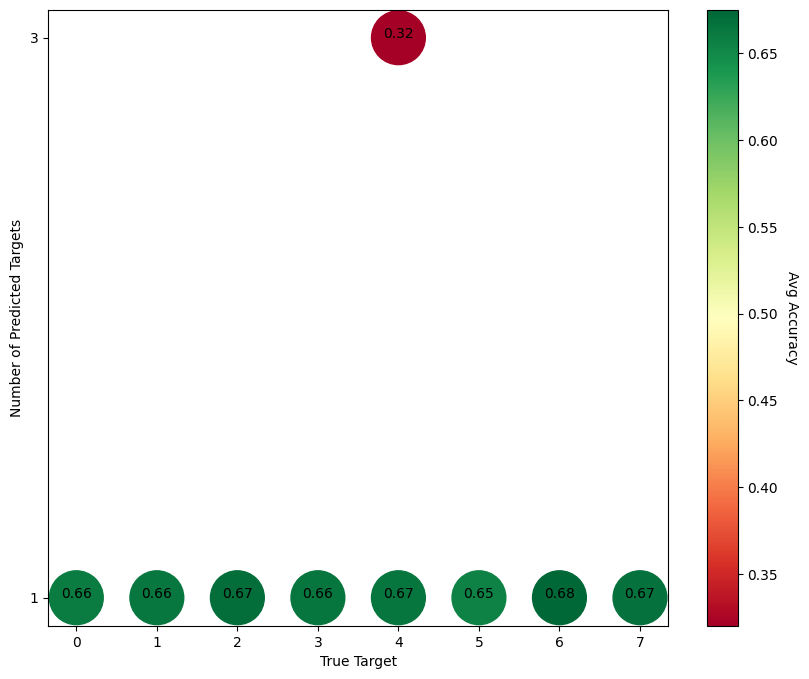

In [79]:
fig = plt.figure(figsize=(10,8))
plt.scatter(res["target"], res["#predicted targets"], c = res["accuracy"], cmap='RdYlGn', s=1500)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Avg Accuracy", rotation=270, labelpad=15)

for i, txt in enumerate(res["accuracy"]):
    plt.annotate(round(txt, 2), (res["target"][i], res["#predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Number of Predicted Targets")
plt.yticks(res["#predicted targets"].unique())
plt.savefig("../Plots/Avg Accuracy for each number of predicted targets and true targets")
plt.show()

In [ ]:
# width = depth = -0.1

# xpos = res["target"] - width/2  # x coordinates of each bar
# ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 # z coordinates of each bar

# dz = res["accuracy"]

# # cs = ['r', 'g', 'b', 'y', 'c', 'k', 'grey'] * len(xpos)
# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = res["colors"]
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors)


# ax.set_xlabel('True Target')
# ax.set_ylabel('Number of Predicted Targets')
# ax.set_zlabel('Avg Accuracy')
# plt.savefig("../Plots/Avg Accuracy for each number of predicted targets and tru targets")
# plt.show()

### Wrong prediction ratio

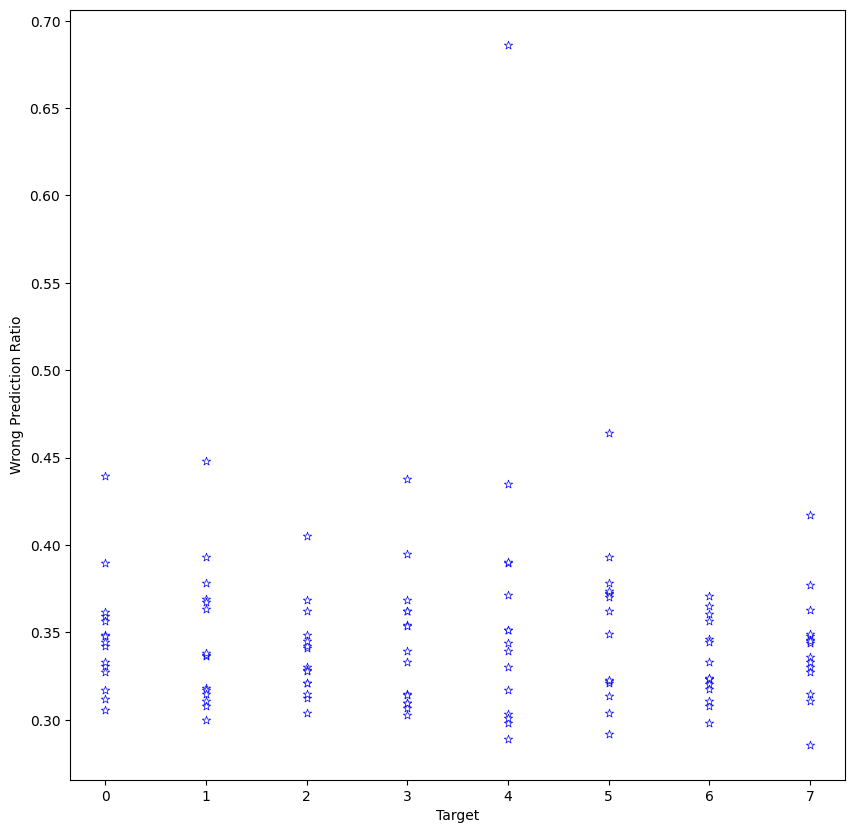

In [80]:
fig = plt.figure(figsize=(10,10))
plt.scatter(accu["target"], accu["wrong prediction time till correct/length"],
            s=40, linewidths=.5, edgecolors='b', marker='*', c='w')
plt.xlabel("Target")
plt.ylabel("Wrong Prediction Ratio")
plt.savefig("../Plots/Wrong prediction ratio")
plt.show()

### Wrong prediction ratio and accuracy

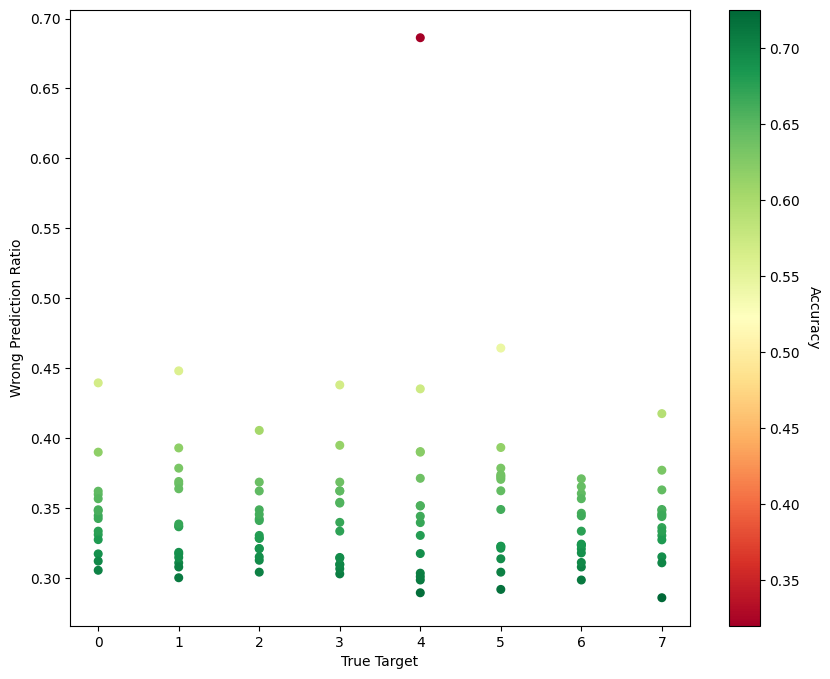

In [81]:
fig = plt.figure(figsize=(10,8))
plt.scatter(accu["target"], accu["wrong prediction time till correct/length"], c = accu["accuracy"], cmap='RdYlGn', s=30)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Accuracy", rotation=270, labelpad=15)

# for i, txt in enumerate(accu["accuracy"]):
#     plt.annotate(round(txt, 2), (accu["target"][i], accu["wrong prediction time till correct/length"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Wrong Prediction Ratio")
plt.savefig("../Plots/Wrong prediction ratio with accuracy")
plt.show()

In [ ]:
# df = accu.copy()

# width = depth = -0.1

# xpos = df["target"] #- width/2  # x coordinates of each bar
# ypos = df["wrong prediction time till correct/length"] #- depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["accuracy"]

# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+depth/10, zpos, width, depth/10, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel("True Target")
# ax.set_ylabel("Wrong Prediction Ratio")
# ax.set_zlabel("Accuracy")
# plt.savefig("../Plots/Wrong prediction ratio with accuracy")
# plt.show()